<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/multi_modal_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal Retrieval using GPT text embedding and CLIP image embedding for Wikipedia Articles

In this notebook, we show how to build a Multi-Modal retrieval system using LlamaIndex.

Wikipedia Text embedding index: Generate GPT text embeddings from OpenAI for texts

Wikipedia Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Query encoder:
* Encoder query text for text index using GPT embedding
* Encoder query text for image index using CLIP embedding

Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts and images raw files for Wikipedia articles
2. Build text index for vector store using GPT embeddings
3. Build image index for vector store using CLIP embeddings
4. Retrieve relevant text and image simultaneously using different query encoding embeddings and vector stores

In [9]:
%pip install -q llama-index-vector-stores-qdrant

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.2/180.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 9.1 MB/s eta 0:00:00
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk

In [10]:
!pip install llama-index-embeddings-clip

In [ ]:
import os
import shutil
from pathlib import Path

# Define the path for the magic-pdf folder
magic_pdf_path = Path("magic-pdf")

# Create the directory where documents will be stored
data_path = Path("documents")
data_path.mkdir(parents=True, exist_ok=True)

# Iterate through each section (subfolder) in magic-pdf
for section in magic_pdf_path.iterdir():
    if section.is_dir():  # Ensure we're only processing directories
        section_path = section / "auto"
        
        # Process the markdown files
        markdown_files = section_path.glob("*.md")
        for markdown_file in markdown_files:
            text = markdown_file.read_text()
            
            # Write the text content into a .txt file
            with open(data_path / f"{section.name}.txt", "w") as fp:
                fp.write(text)

        # Copy images from the section's images folder to the documents directory
        images_path = section_path / "images"
        if images_path.exists() and images_path.is_dir():
            for image_file in images_path.glob("*"):
                shutil.copy(image_file, data_path)


## Load and Download Multi-Modal datasets including texts and images from Wikipedia
Parse wikipedia articles and save into local folder

## Parse Wikipedia Images and texts. Load into local folder

In [7]:
import os

from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


## Build Multi Modal Vector Store using Text and Image embeddings under different collections

In [1]:
import openai

openai.api_key = 'secutirty reason, I deleted the key'

In [2]:
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_d_0")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection_0"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection_0"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("documents_32_40/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)


/Users/zihan/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Plot downloaded Images from Wikipedia

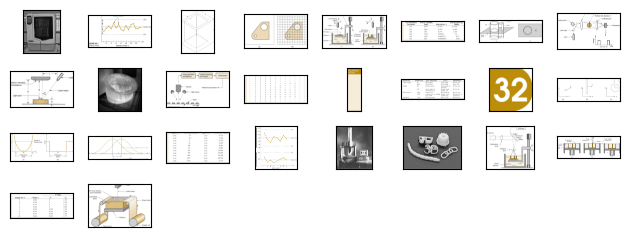

In [9]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import os

# Define the path for the documents folder
magic_pdf_path = Path("documents_32_40")
image_paths = list(magic_pdf_path.glob("*.jpg"))

# Function to plot images
def plot_images(image_paths):
    images_shown = 0
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path).convert("RGB")
            
            plt.subplot(8, 8, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            
            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()
    plt.show()

# Call the function with the image paths
plot_images(image_paths)


### Build a separate CLIP image embedding index under a differnt collection `wikipedia_img`

In [10]:
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

## Get Multi-Modal retrieval results for some example queries

In [11]:
test_query = "In brazing, the base metals melt at temperatures above 840F (450C) while in soldering they melt at 840F (450C) or below: (a) true, or (b) false."
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

In [12]:
retrieval_results

[NodeWithScore(node=TextNode(id_='bbca6680-e84e-4704-a05c-e448e5e04bf5', embedding=None, metadata={'file_path': '/Users/zihan/Desktop/documents_32_40/sec32.md', 'file_name': 'sec32.md', 'file_size': 51204, 'creation_date': '2024-08-24', 'last_modified_date': '2024-08-21'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='78dca79b-b5db-4448-b2aa-99b418b4e48a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/zihan/Desktop/documents_32_40/sec32.md', 'file_name': 'sec32.md', 'file_size': 51204, 'creation_date': '2024-08-24', 'last_modified_date': '2024-08-21'}, hash='9eecb88807fb9f894ca42a89815df835eab5ef6b15555144c727965efad7fcc8'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='0a8

**Node ID:** bbca6680-e84e-4704-a05c-e448e5e04bf5<br>**Similarity:** 0.7574864610350526<br>**Text:** 32.2.2  POWDER-BASED SYSTEMS

The common feature of the additive manufacturing processes described below is  that the starting material is powder.  These processes are sometimes referred to by  the...<br>

**Node ID:** cbe6efa8-7d16-46ab-a79c-b518882e15a8<br>**Similarity:** 0.7572167060144999<br>**Text:** 32.2.3  MOLTEN MATERIAL SYSTEMS

These additive technologies work by depositing material onto the layer at close to  the material’s melting point. Although the material is molten just before deposi...<br>

**Node ID:** 831468b7-fb2a-448d-9cd2-840c568dd442<br>**Similarity:** 0.7461392924636601<br>**Text:** 32.2.4  SOLID SHEET–BASED SYSTEMS

The common feature in these additive manufacturing systems is that the starting  material is a solid sheet. In this section a solid-sheet system called laminated-...<br>

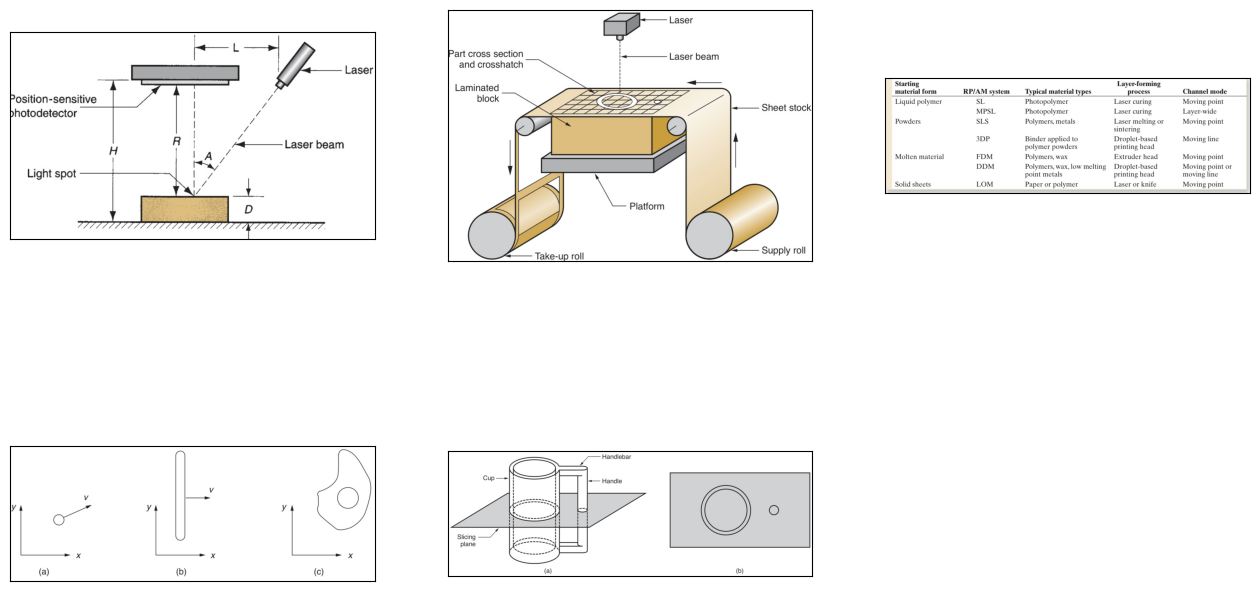

In [13]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** cbe6efa8-7d16-46ab-a79c-b518882e15a8<br>**Similarity:** 0.7758426888668344<br>**Text:** 32.2.3  MOLTEN MATERIAL SYSTEMS

These additive technologies work by depositing material onto the layer at close to  the material’s melting point. Although the material is molten just before deposi...<br>

**Node ID:** bbca6680-e84e-4704-a05c-e448e5e04bf5<br>**Similarity:** 0.7647105559033709<br>**Text:** 32.2.2  POWDER-BASED SYSTEMS

The common feature of the additive manufacturing processes described below is  that the starting material is powder.  These processes are sometimes referred to by  the...<br>

**Node ID:** 3e04c367-4329-44d4-9eff-113412d01f22<br>**Similarity:** 0.7619346112116403<br>**Text:** Starting materials are wax  and several polymers, including ABS and polycarbonate. These materials are non- toxic, allowing the FDM machine to be set up in an ofﬁ  ce environment. A collection  of ...<br>

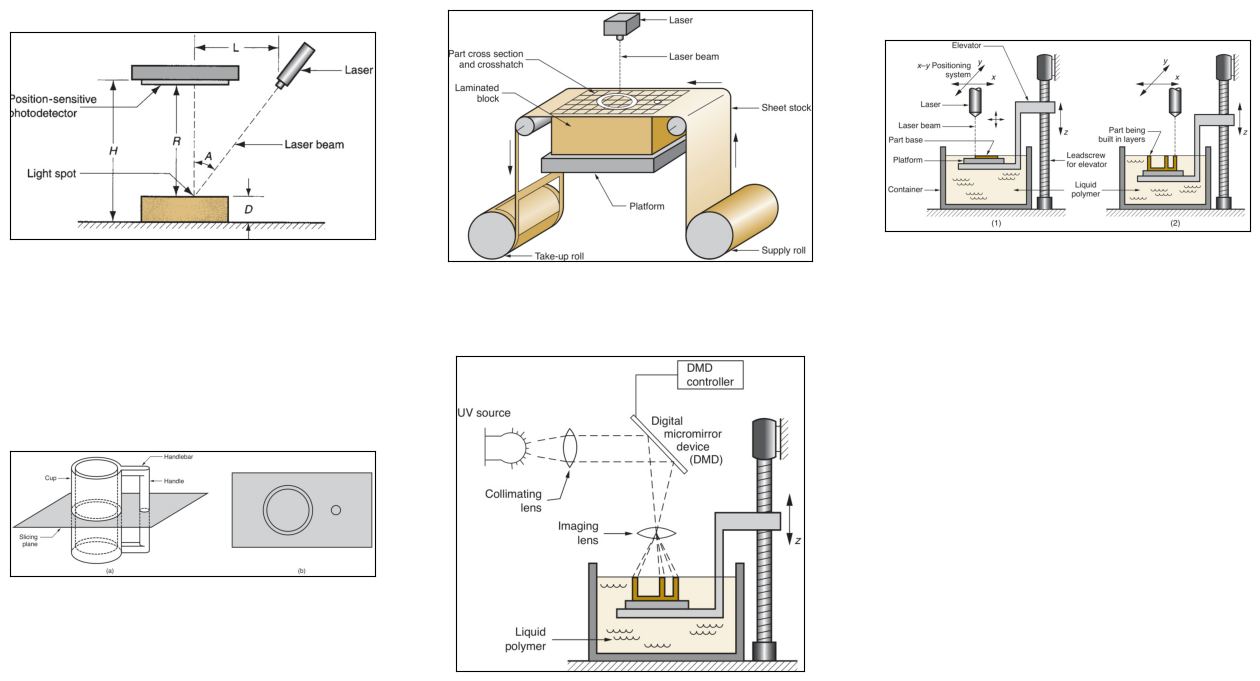

In [14]:
test_query = "A soldering gun is capable of injecting molten solder metal into the joint area: (a) true, or (b) false."
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

**Node ID:** 831468b7-fb2a-448d-9cd2-840c568dd442<br>**Similarity:** 0.7381256255238069<br>**Text:** 32.2.4  SOLID SHEET–BASED SYSTEMS

The common feature in these additive manufacturing systems is that the starting  material is a solid sheet. In this section a solid-sheet system called laminated-...<br>

**Node ID:** 222d1852-c8c5-4bdd-86e2-b2e955158707<br>**Similarity:** 0.7374936354546566<br>**Text:** Additive Manufacturing Processes

AM processes can be classiﬁ  ed in various ways. The classiﬁ  cation system used here is  based on the form of the starting material in the process: (1) liquid-bas...<br>

**Node ID:** 2a9507f3-8b3f-47a1-b547-d0b643858bf6<br>**Similarity:** 0.7351620383143768<br>**Text:** 2.  Tessellation of the geometric model .  In this step, the CAD model is converted into  a format that approximates its surfaces by triangles, with their vertices arranged to  distinguish the obje...<br>

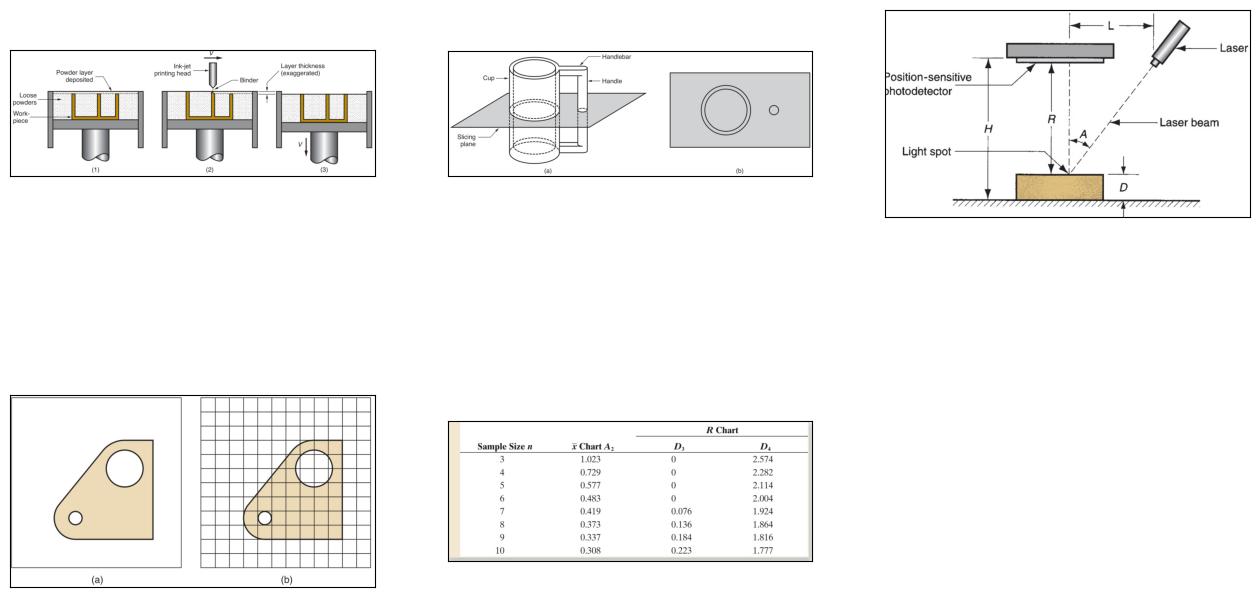

In [15]:
test_query = "Adhesively bonded joints are strongest under which type of stresses (pick two best answers): (a) cleavage, (b) peeling, (c) shear, and (d) tension."
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)

In [75]:
test_query = """Clearances between surfaces in brazing are which one of the following: (a) 0.0025 to 0.025 mm (0.0001 to 0.001 in.), (b) 0.025 to 0.250 mm (0.001 to 0.010 in.), (c) 0.250 to 2.50 mm (0.010 to 0.100 in.), or (d) 2.5 to 5.0 mm (0.10 to 0.20 in.)."""
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=3)
retrieval_results = retriever.retrieve(test_query)

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)


RuntimeError: Input Clearances between surfaces in brazing are which one of the following: (a) 0.0025 to 0.025 mm (0.0001 to 0.001 in.), (b) 0.025 to 0.250 mm (0.001 to 0.010 in.), (c) 0.250 to 2.50 mm (0.010 to 0.100 in.), or (d) 2.5 to 5.0 mm (0.10 to 0.20 in.). is too long for context length 77

In [24]:
retrieved_image = []
retrieved_text = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        retrieved_text.append(res_node.node.text)
        display_source_node(res_node, source_length=200)

**Node ID:** bbca6680-e84e-4704-a05c-e448e5e04bf5<br>**Similarity:** 0.765579436349547<br>**Text:** 32.2.2  POWDER-BASED SYSTEMS

The common feature of the additive manufacturing processes described below is  that the starting material is powder.  These processes are sometimes referred to by  the...<br>

**Node ID:** 7e551bd8-39cb-4d2a-b05f-51405943a61d<br>**Similarity:** 0.7654733281254282<br>**Text:** H istorical  N ote  32.1   Rapid Prototyping and Additive Manufacturing [4]

It should be noted that the historical development  of rapid prototyping and additive manufacturing is  based on several...<br>

**Node ID:** 831468b7-fb2a-448d-9cd2-840c568dd442<br>**Similarity:** 0.7650463170883651<br>**Text:** 32.2.4  SOLID SHEET–BASED SYSTEMS

The common feature in these additive manufacturing systems is that the starting  material is a solid sheet. In this section a solid-sheet system called laminated-...<br>

In [76]:
from llama_index.core import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngines
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

OPENAI_API_KEY = "security reason, deleted"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=4000
)


qa_tmpl_str = (
"""You are an top student in manufacturing major. You are in an exam and you need to answering the following MCQ based on the context provided and what you know regarding manufacturing process and materials correctly. 
Please think step by step then provide the choose the correct answer(s) carefully as yout finnal answer, remember you need to provide the letter choice. for the context choice will result a zero even it is correct:\n

You must provide answer in the following format:

"Explanation": "The capital of France is Paris, which is a major European city and a global center for art, fashion, and culture.", "YourChoice": "A"

{context_str}\n
Answer the following question:
Query: {query_str}\n
Answer: """
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    llm=openai_mm_llm, text_qa_template=qa_tmpl
)

query_str = """Clearances between surfaces in brazing are which one of the following"""
result = query_engine.query(query_str)


print(result)

ImportError: cannot import name 'SimpleMultiModalQueryEngines' from 'llama_index.core.query_engine' (/Users/zihan/miniconda3/lib/python3.11/site-packages/llama_index/core/query_engine/__init__.py)

In [68]:
result.metadata["text_nodes"]

[NodeWithScore(node=TextNode(id_='cbe6efa8-7d16-46ab-a79c-b518882e15a8', embedding=None, metadata={'file_path': '/Users/zihan/Desktop/documents_32_40/sec32.md', 'file_name': 'sec32.md', 'file_size': 51204, 'creation_date': '2024-08-24', 'last_modified_date': '2024-08-21'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='9f90dfa6-f13a-4baf-990e-d87da81dbbc8', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/Users/zihan/Desktop/documents_32_40/sec32.md', 'file_name': 'sec32.md', 'file_size': 51204, 'creation_date': '2024-08-24', 'last_modified_date': '2024-08-21'}, hash='4cde1b7dfa0c5a8ceb948bb0325a66fa3eea1dc4bbc30b1471cacd8128667ed3'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='3e0

**Node ID:** cbe6efa8-7d16-46ab-a79c-b518882e15a8<br>**Similarity:** 0.7631169476525267<br>**Text:** 32.2.3  MOLTEN MATERIAL SYSTEMS

These additive technologies work by depositing material onto the layer at close to  the material’s melting point. Although the material is molten just before deposi- tion, it must be in a solid or semisolid state immediately after it is deposited  to  maintain the desired shape. As a practical matter, the melting requirement limits  the materials that can be used with these systems to thermoplastic polymers or  wax. Two representative systems are described below: (1) fused deposition model- ing, which uses an extrusion head to dispense the material; and (2) droplet deposi- tion manufacturing, which uses a multichannel printing head.  

Fused-Deposition Modeling  Fused-deposition modeling (FDM) is an RP process  in which a ﬁ  lament of wax and/or thermoplastic polymer is extruded onto the  exist  ing part surface from a work head to complete each new layer. The work head  is controlled in the $x{-}y$  plane during each layer and then moved up by a distance  equal to one layer in the $z$ -direction. The starting material is a solid ﬁ  lament with  typical diameter $=1.25\:\mathrm{mm}$  (0.050 in) fed from a spool into the work head, which  heats the material to about $0.5^{\circ}\mathrm{C}\left(\sim\!1^{\circ}\mathrm{F}\right)$  above its melting point before extruding it  onto the part surface. The extrudate is solidiﬁ  ed and cold welded to the cooler part  surface in about 0.1 sec. If a support structure is needed, that material is usually  extruded by a second extrusion head using a different material that can be readily  separated from the main part. The part is fabricated from the base up, using a  layer-by-layer procedure similar to other RP systems. A disadvantage of FDM is its  relatively slow speed, because the deposited material is applied in a moving-point  channel mode, and the work head cannot be moved with the high speed of a laser  spot. Also, the use of an extruder, with its circular nozzle oriﬁ  ce, makes it difﬁ  cult  to form sharp corners [4].  

FDM was developed by Stratasys Inc., which sold its ﬁ  rst machine in 1990. Today,  there are more FDM machines throughout the world than any other type of AM  machine [4]. The starting data is a CAD geometric model that is processed by  Stratasys’s software modules QuickSlice ® ; and SupportWork ™ . QuickSlice ®  is used  to slice the model into layers, and SupportWork ™  is used to generate any support  

!  
FIGURE 32.7  Collection  of parts produced by  fused deposition  modeling. (Courtesy  of George E. Kane  Manufacturing  Technology Laboratory,  Lehigh University.)  

structures that are required during the build process. The slice (layer) thickness is  typically set from 0.25 to $0.33\,\mathrm{mm}$  (0.01–0.013 in), but for ﬁ  ner details, layer thickness  can be set to a minimum of $0.076\:\mathrm{mm}\:(0.003\:\mathrm{in})$ [4]. Up to about  $400\,\mathrm{mm}$  of ﬁ  lament  can be deposited per second by the extrusion work head. Starting materials are wax  and several polymers, including ABS and polycarbonate. These materials are non- toxic, allowing the FDM machine to be set up in an ofﬁ  ce environment. A collection  of plastic parts made by fused deposition modeling is shown in Figure 32.7, and the  FDM machine that made these parts is shown in Figure 32.8.  

Droplet Deposition Manufacturing   This process, also known as ballistic-particle  manufacturing, operates by melting the starting material and shooting small droplets  onto a previously formed layer. The term droplet deposition manufacturing (DDM)  refers to the fact that small particles of work material are deposited as projectile  droplets from the work head nozzle. The liquid droplets cold weld to the surface  to form a new layer.<br>

**Node ID:** 3e04c367-4329-44d4-9eff-113412d01f22<br>**Similarity:** 0.7546251590016283<br>**Text:** Starting materials are wax  and several polymers, including ABS and polycarbonate. These materials are non- toxic, allowing the FDM machine to be set up in an ofﬁ  ce environment. A collection  of plastic parts made by fused deposition modeling is shown in Figure 32.7, and the  FDM machine that made these parts is shown in Figure 32.8.  

Droplet Deposition Manufacturing   This process, also known as ballistic-particle  manufacturing, operates by melting the starting material and shooting small droplets  onto a previously formed layer. The term droplet deposition manufacturing (DDM)  refers to the fact that small particles of work material are deposited as projectile  droplets from the work head nozzle. The liquid droplets cold weld to the surface  to form a new layer. The deposition of droplets for each new layer is controlled by  a moving $x$ - y  work head that operates in a point-wise manner, in which the path is  based on a cross section of a CAD geometric model that has been sliced into layers.  For geometries that require a support structure, two work heads are used, one to  dispense the polymer to make the object itself, and the second to deposit another  material for the support. After each layer has been applied, the platform supporting  the part is lowered a certain distance corresponding to the layer thickness, in prepa- ration for the next layer.  

Several commercial additive manufacturing machines are based on this general  operating principle, the differences being in the type of material that is deposited  

!  
FIGURE 32.8  Fused  deposition modeling  machine. (Courtesy of  George E. Kane  Manufacturing  Technology Laboratory,  Lehigh University.)  

and the corresponding technique by which the work head operates to melt and  apply the material. An important criterion that must be satisﬁ  ed by the starting  material is that it be readily melted and solidiﬁ  ed. Work materials used in DDM  include wax and thermoplastics. Metals with low melting point, such as tin and  aluminum, have also been tested. Improvements in the channel modes include the  use of moving line printing heads that operate much like ink-jet printers.<br>

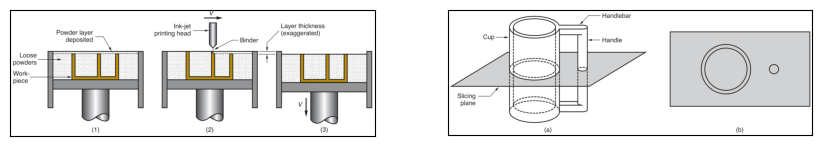

In [69]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in result.metadata["text_nodes"]:
    display_source_node(text_node, source_length=8000)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)

In [79]:
import pandas as pd
import glob

# Define the file path pattern to match all CSV files ending with -MCQ.csv
csv_file_pattern = 'Questions/*-MCQ.csv'
# csv_file_pattern = '/home/zihan/Desktop/Manufacturing_QA/QA_Pairs/ch02-MCQ.csv'

# Use glob to find all files matching the pattern
csv_files = glob.glob(csv_file_pattern)

# Read all matching CSV files into a list of DataFrames
dfs = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one
df = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame
df

,Question,Answer
0,Batch model lines are most suited to which one...,Answer. (c)
1,Manual methods of workpart transfer are probab...,Answer. (a)
2,Precedence constraints are best described by w...,Answer. (d)
3,Which of the following phrases are most approp...,"Answer. (c), (d), and (f)."
4,The transfer line is most closely associated w...,Answer. (c)
5,A dial indexing machine uses which one of the ...,Answer. (d)
6,The line efficiency (proportion uptime) on an ...,Answer. (a) and (c).
7,"In brazing, the base metals melt at temperatur...",Answer. (b) Neither brazing or soldering invol...
8,The strength of a brazed joint is typically wh...,Answer. (b)
9,Scarfing in the brazing of a butt joint involv...,Answer. (b) Scarfing involves a preparation of...


In [98]:
questions = df['Question'].tolist()
results = []
text_reasons = []
image_reasons = []
for question in questions:
    result = query_engine.query(question)
    text_reason = result.metadata["text_nodes"]
    image_reason = result.metadata["image_nodes"]
    match = re.search(r'"Explanation": "(.*?)", "YourChoice": "(.*?)"', result.response)
    if match:
        explanation_part = match.group(1)
        your_choice_part = match.group(2)
        
        # Reconstruct the dictionary
        parsed_dict = {
            "Explanation": explanation_part,
            "YourChoice": your_choice_part
        }
        results.append(parsed_dict)
    print(result)
    # results.append(result.response) 
    text_reasons.append(text_reason)
    image_reasons.append(image_reason)


result_df = pd.DataFrame(results, columns=['llamaindex_answer'])
text_reasons_df = pd.DataFrame(text_reasons, columns=['llamaindex_text_reasons'])
images_reasons_df = pd.DataFrame(image_reasons, columns=['llamaindex_images_reasons'])
output_df = pd.concat([df, result_df, text_reasons_df, images_reasons_df], axis=1)
output_df
    

"Explanation": "Batch model lines are most suited to medium production situations because they are designed to handle moderate volumes of products with some level of customization. This allows for flexibility in production while maintaining efficiency.", "YourChoice": "C"
"Explanation": "Manual methods of workpart transfer are typically done one part at a time, similar to how parts are transferred in a synchronous mechanized system where each part moves to the next station in a coordinated manner. This is in contrast to asynchronous transfer, where parts move independently, and continuous transfer, where parts move in a continuous flow.", "YourChoice": "C"
"Explanation": "Precedence constraints refer to the sequence in which work elements must be performed. This ensures that certain tasks are completed before others can begin, maintaining the logical and necessary order of operations in a manufacturing process.", "YourChoice": "D"
Explanation: Based on the provided context, automated w

,Question,Answer,llamaindex_answer,llamaindex_text_reasons,llamaindex_images_reasons
0,Batch model lines are most suited to which one...,Answer. (c),"""Explanation"": ""Batch model lines are most sui...",Node ID: 222d1852-c8c5-4bdd-86e2-b2e955158707\...,Node ID: 87544150-9c0a-4abf-bb37-a41caa969f9e\...
1,Manual methods of workpart transfer are probab...,Answer. (a),"""Explanation"": ""Manual methods of workpart tra...",Node ID: 635a1f0e-0756-4d95-a4ad-37b6b2ce5df6\...,Node ID: e03cc2ca-7454-41a5-9861-eeb6530c58f1\...
2,Precedence constraints are best described by w...,Answer. (d),"""Explanation"": ""Precedence constraints refer t...",Node ID: d51d9d86-284f-4356-afd8-603a6ae214da\...,Node ID: 6f9af665-b713-43ce-b1c0-9043cb2a9798\...
3,Which of the following phrases are most approp...,"Answer. (c), (d), and (f).","Explanation: Based on the provided context, au...",Node ID: 635a1f0e-0756-4d95-a4ad-37b6b2ce5df6\...,Node ID: f0503870-f328-407a-a779-5f31606b1f9b\...
4,The transfer line is most closely associated w...,Answer. (c),"""Explanation"": ""A transfer line is a manufactu...",Node ID: 222d1852-c8c5-4bdd-86e2-b2e955158707\...,Node ID: e03cc2ca-7454-41a5-9861-eeb6530c58f1\...
5,A dial indexing machine uses which one of the ...,Answer. (d),"""Explanation"": ""A dial indexing machine uses s...",Node ID: bf3fc349-a900-4db7-8cc2-1d696cfa8f97\...,Node ID: 73aa8247-bbfa-4d37-aa8c-2c4a7487bc8c\...
6,The line efficiency (proportion uptime) on an ...,Answer. (a) and (c).,"""Explanation"": ""The line efficiency on an auto...",Node ID: aa272242-7cd4-4e23-850a-2b63651ff497\...,Node ID: 891d7aa5-b1f3-4d39-a761-6d4eeedede7b\...
7,"In brazing, the base metals melt at temperatur...",Answer. (b) Neither brazing or soldering invol...,"""Explanation"": ""In brazing, the base metals do...",Node ID: bbca6680-e84e-4704-a05c-e448e5e04bf5\...,Node ID: f0503870-f328-407a-a779-5f31606b1f9b\...
8,The strength of a brazed joint is typically wh...,Answer. (b),"""Explanation"": ""The strength of a brazed joint...",Node ID: bbca6680-e84e-4704-a05c-e448e5e04bf5\...,Node ID: e03cc2ca-7454-41a5-9861-eeb6530c58f1\...
9,Scarfing in the brazing of a butt joint involv...,Answer. (b) Scarfing involves a preparation of...,"""Explanation"": ""Scarfing in the brazing of a b...",Node ID: cbe6efa8-7d16-46ab-a79c-b518882e15a8\...,Node ID: e03cc2ca-7454-41a5-9861-eeb6530c58f1\...


In [105]:
import re
import pandas as pd

# # Example list of strings to parse
# try_results = [
#     '"Explanation": "Batch model lines are most suited to medium production situations because they are designed to handle moderate volumes of products with some level of customization. This allows for flexibility in production while maintaining efficiency.", "YourChoice": "C"',
#     # Add more items as needed
# ]

# Parse the results using regex
parsed_results = []
for item in results:
    # Use regex to extract "Explanation" and "YourChoice"
    match = re.search(r'"Explanation": "(.*?)", "YourChoice": "(.*?)"', item)
    if match:
        explanation_part = match.group(1)
        your_choice_part = match.group(2)
        
        # Reconstruct the dictionary
        parsed_dict = {
            "Explanation_llama": explanation_part,
            "YourChoice_llama": your_choice_part
        }
        parsed_results.append(parsed_dict)

# Convert the parsed results into a DataFrame
Outputs_df_2 = pd.DataFrame(parsed_results)

# Display the DataFrame
Outputs_df_2


,Explanation_llama,YourChoice_llama
0,Batch model lines are most suited to medium pr...,C
1,Manual methods of workpart transfer are typica...,C
2,Precedence constraints refer to the sequence i...,D
3,A transfer line is a manufacturing system wher...,C
4,A dial indexing machine uses synchronous workp...,D
5,The line efficiency on an automated line can b...,"A, C"
6,"In brazing, the base metals do not melt; inste...",B
7,The strength of a brazed joint is typically we...,C
8,Scarfing in the brazing of a butt joint does n...,B
9,Brazing offers several advantages over other j...,"A, B, C"


In [106]:
output_df = pd.concat([df, Outputs_df_2, text_reasons_df, images_reasons_df], axis=1)
output_df

,Question,Answer,Explanation_llama,YourChoice_llama,llamaindex_text_reasons,llamaindex_images_reasons
0,Batch model lines are most suited to which one...,Answer. (c),Batch model lines are most suited to medium pr...,C,Node ID: 222d1852-c8c5-4bdd-86e2-b2e955158707\...,Node ID: 87544150-9c0a-4abf-bb37-a41caa969f9e\...
1,Manual methods of workpart transfer are probab...,Answer. (a),Manual methods of workpart transfer are typica...,C,Node ID: 635a1f0e-0756-4d95-a4ad-37b6b2ce5df6\...,Node ID: e03cc2ca-7454-41a5-9861-eeb6530c58f1\...
2,Precedence constraints are best described by w...,Answer. (d),Precedence constraints refer to the sequence i...,D,Node ID: d51d9d86-284f-4356-afd8-603a6ae214da\...,Node ID: 6f9af665-b713-43ce-b1c0-9043cb2a9798\...
3,Which of the following phrases are most approp...,"Answer. (c), (d), and (f).",A transfer line is a manufacturing system wher...,C,Node ID: 635a1f0e-0756-4d95-a4ad-37b6b2ce5df6\...,Node ID: f0503870-f328-407a-a779-5f31606b1f9b\...
4,The transfer line is most closely associated w...,Answer. (c),A dial indexing machine uses synchronous workp...,D,Node ID: 222d1852-c8c5-4bdd-86e2-b2e955158707\...,Node ID: e03cc2ca-7454-41a5-9861-eeb6530c58f1\...
5,A dial indexing machine uses which one of the ...,Answer. (d),The line efficiency on an automated line can b...,"A, C",Node ID: bf3fc349-a900-4db7-8cc2-1d696cfa8f97\...,Node ID: 73aa8247-bbfa-4d37-aa8c-2c4a7487bc8c\...
6,The line efficiency (proportion uptime) on an ...,Answer. (a) and (c).,"In brazing, the base metals do not melt; inste...",B,Node ID: aa272242-7cd4-4e23-850a-2b63651ff497\...,Node ID: 891d7aa5-b1f3-4d39-a761-6d4eeedede7b\...
7,"In brazing, the base metals melt at temperatur...",Answer. (b) Neither brazing or soldering invol...,The strength of a brazed joint is typically we...,C,Node ID: bbca6680-e84e-4704-a05c-e448e5e04bf5\...,Node ID: f0503870-f328-407a-a779-5f31606b1f9b\...
8,The strength of a brazed joint is typically wh...,Answer. (b),Scarfing in the brazing of a butt joint does n...,B,Node ID: bbca6680-e84e-4704-a05c-e448e5e04bf5\...,Node ID: e03cc2ca-7454-41a5-9861-eeb6530c58f1\...
9,Scarfing in the brazing of a butt joint involv...,Answer. (b) Scarfing involves a preparation of...,Brazing offers several advantages over other j...,"A, B, C",Node ID: cbe6efa8-7d16-46ab-a79c-b518882e15a8\...,Node ID: e03cc2ca-7454-41a5-9861-eeb6530c58f1\...


In [107]:
csv_file_path = 'Test32_40.csv'
df.to_csv(csv_file_path, index=False)